In [1]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

Предположим в июле провели специальную акцию, направленную на улучшение ретеншена. Новым юзерам слали письмо с купоном. Сработала ли акция?

https://drive.google.com/file/d/18CZKLXpbZfR44SunmzSuFvc0kI9U8n_K/view?usp=sharing

сделать можно на питоне в юпитер или экселе или в гугл шите, даже можете в sql сделать, как удобнее.

обратно нужно дать файл с формулами или кодом и описание того, как получился результат поэтапно.

In [2]:
df = pd.read_csv("C:/Users/Mr0Wo/OneDrive/Рабочий стол/Git_repositories/Data-science-cases/Analytical-cases/Retention-case/data.csv")

In [3]:
df.head()

,user_id,order_id,reg_date,transaction_date,revenue
0,57562,94545.0,2013-12-22,2015-07-16,1088
1,40047,81824.0,2013-11-24,2015-01-19,1027
2,48153,144851.0,2015-07-03,2015-10-29,601
3,54591,116111.0,2013-07-12,2015-04-30,881
4,39789,134943.0,2013-05-25,2015-07-21,984


### EDA

In [4]:
df.dtypes

user_id               int64
order_id            float64
reg_date             object
transaction_date     object
revenue               int64
dtype: object

In [5]:
df.reg_date = pd.to_datetime(df.reg_date, format='%Y-%m-%d')
df.transaction_date = pd.to_datetime(df.transaction_date, format='%Y-%m-%d')

In [6]:
df['reg_date'].agg({'min', 'max'})

min   1900-01-01
max   2015-11-20
Name: reg_date, dtype: datetime64[ns]

In [7]:
df['transaction_date'].agg({'min', 'max'})

min   2015-01-01
max   2015-11-20
Name: transaction_date, dtype: datetime64[ns]

<Axes: >

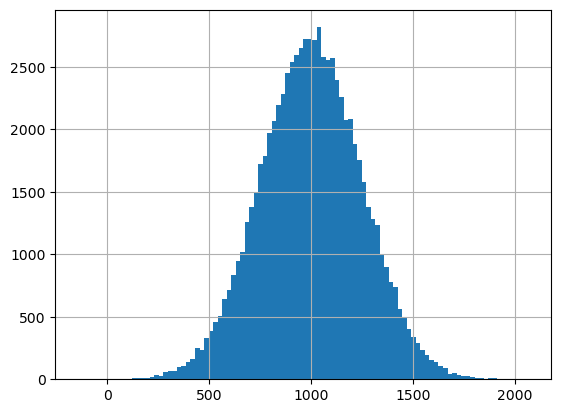

In [8]:
df['revenue'].hist(bins=100)

In [9]:
df['user_id'].nunique()

48214

In [10]:
df['reg_date'].nunique()

1363

In [11]:
df.groupby('user_id')['reg_date'].apply(list).str.len().value_counts()  # ???

1    28901
2    12605
3     4739
4     1470
5      379
6       92
7       23
8        4
9        1
Name: reg_date, dtype: int64

<Axes: >

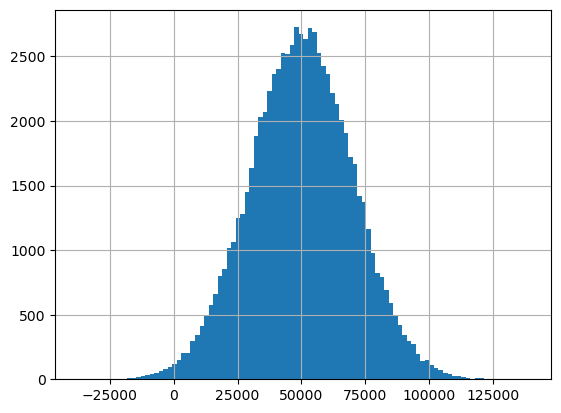

In [12]:
df['user_id'].hist(bins=100)

### Скорее всего такое большое кол-во дат регистраиции пользователей появилось в следствии добавления искуственных данных, поскольку в нормальных условиях у пользователей может быть только 1 дата регистрации, отберем только таких пользователй

In [13]:
t = df.groupby('user_id')['reg_date'].apply(list).str.len().reset_index().reset_index()

In [14]:
users_with_one_reg_date = t[t.reg_date == 1]['user_id'].reset_index().drop(columns='index')

In [15]:
df_with_1_reg_data = df.merge(users_with_one_reg_date, on='user_id')

In [16]:
df_with_1_reg_data['transaction_month'] = df_with_1_reg_data['transaction_date'].to_numpy().astype('datetime64[M]')
df_with_1_reg_data['reg_month'] = df_with_1_reg_data['reg_date'].to_numpy().astype('datetime64[M]')

In [27]:
df_with_1_reg_data.head()

,user_id,order_id,reg_date,transaction_date,revenue,transaction_month,reg_month,key
0,48153,144851.0,2015-07-03,2015-10-29,601,2015-10-01,2015-07-01,1
1,72102,84827.0,2015-08-09,2015-11-18,946,2015-11-01,2015-08-01,1
2,50977,136343.0,2012-06-27,2015-03-13,1028,2015-03-01,2012-06-01,1
3,20688,123746.0,2012-05-11,2015-08-03,1002,2015-08-01,2012-05-01,1
4,102818,145292.0,2013-10-31,2015-07-22,1163,2015-07-01,2013-10-01,1


In [18]:
min_date = df_with_1_reg_data['transaction_month'].min()
max_date = df_with_1_reg_data['transaction_month'].max()

In [19]:
month = pd.DataFrame(pd.date_range(min_date, max_date, freq='MS')).rename(columns={0:'month'})

In [20]:
month.head()

,month
0,2015-01-01
1,2015-02-01
2,2015-03-01
3,2015-04-01
4,2015-05-01


In [21]:
df_with_1_reg_data['key'] = 1
month['key'] = 1

In [22]:
month_revenue = df_with_1_reg_data.groupby(['user_id', 'transaction_month'])['revenue'].agg('sum').reset_index()

In [23]:
report = df_with_1_reg_data[['user_id', 'reg_month', 'key']] \
                                            .merge(month, on='key') \
                                            .drop(columns='key') \
                                            .rename(columns={'month' : 'transaction_month'})
report.head()

,user_id,reg_month,transaction_month
0,48153,2015-07-01,2015-01-01
1,48153,2015-07-01,2015-02-01
2,48153,2015-07-01,2015-03-01
3,48153,2015-07-01,2015-04-01
4,48153,2015-07-01,2015-05-01


In [24]:
28901 * 11

317911

In [25]:
report = report[report.reg_month <= report.transaction_month].merge(month_revenue, on=['user_id', 'transaction_month'], how='left')

In [29]:
report['active_user'] = (report['revenue'] > 0) * 1

In [30]:
report.head()

,user_id,reg_month,transaction_month,revenue,active_user
0,48153,2015-07-01,2015-07-01,NaN,0
1,48153,2015-07-01,2015-08-01,NaN,0
2,48153,2015-07-01,2015-09-01,NaN,0
3,48153,2015-07-01,2015-10-01,601.0,1
4,48153,2015-07-01,2015-11-01,NaN,0


In [37]:
report_pivot = report.pivot_table(index='reg_month', 
                   columns='transaction_month', 
                   values='active_user', 
                   aggfunc='mean')

In [40]:
report_pivot

transaction_month,2015-01-01,2015-02-01,2015-03-01,2015-04-01,2015-05-01,2015-06-01,2015-07-01,2015-08-01,2015-09-01,2015-10-01,2015-11-01
reg_month,,,,,,,,,,,
1900-01-01,0.045455,0.090909,0.227273,0.136364,0.136364,0.318182,0.000000,0.000000,0.045455,0.000000,0.000000
2012-02-01,0.000000,0.333333,0.000000,0.000000,0.333333,0.000000,0.000000,0.000000,0.000000,0.000000,0.333333
2012-03-01,0.095588,0.088235,0.036765,0.066176,0.102941,0.161765,0.058824,0.088235,0.088235,0.125000,0.088235
2012-04-01,0.087591,0.124088,0.131387,0.080292,0.065693,0.116788,0.072993,0.058394,0.109489,0.109489,0.043796
2012-05-01,0.046729,0.112150,0.065421,0.112150,0.102804,0.084112,0.065421,0.149533,0.084112,0.084112,0.093458
2012-06-01,0.055249,0.077348,0.060773,0.116022,0.127072,0.077348,0.071823,0.093923,0.093923,0.110497,0.116022
2012-07-01,0.071942,0.093525,0.115108,0.100719,0.122302,0.071942,0.086331,0.086331,0.071942,0.115108,0.064748
2012-08-01,0.059406,0.118812,0.099010,0.089109,0.079208,0.069307,0.099010,0.148515,0.079208,0.089109,0.069307
2012-09-01,0.142857,0.064286,0.107143,0.107143,0.114286,0.092857,0.078571,0.107143,0.064286,0.057143,0.064286


<Axes: xlabel='transaction_month', ylabel='reg_month'>

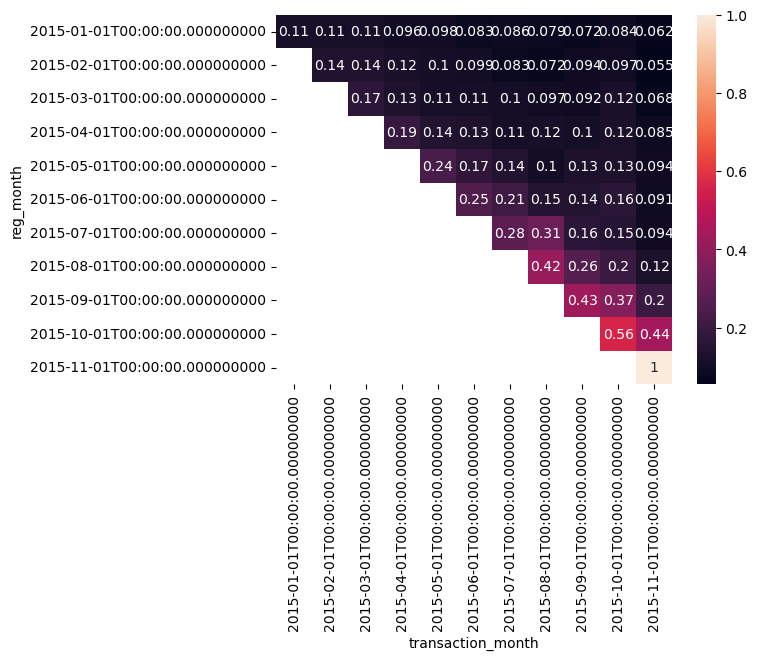

In [44]:
import seaborn as sns
sns.heatmap(report_pivot[report_pivot.index > '2014-12-01'], annot=True)

## Акция действительно улучшила ретеншн для пользователей, которые зарегистрировались в июле 2015г и позднее. Из графика видно, что значительно увеличился процент удержанных клиентов в первый месяц после месяца регистрации, и незначительно во второй месяц после месяца регистрации. Также эта акция положителньо сказалась на конверсии в месяц регистрации пользователей, увеличение практически в 2 раза